In [377]:

import time

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta, 
    RegressionEnsembleModel)               # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import ( 
    AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset, HeartRateDataset, 
    IceCreamHeaterDataset, MonthlyMilkDataset, SunspotsDataset)


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)



TRACE = False                 # print also the suboptimal models while SARIMA tuning process is running
MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default

TRAIN = dt.datetime(1957,5,1).date()            # training until date AirPassengers
# TRAIN = "20051201"                            # training until date AusBeer
# TRAIN = 1600                                  # training until index HeartRate (if float, then interpret as % split)
# TRAIN = dt.datetime(1966,3,1).date()          # training MonthlyMilk or Sunspots


In [378]:
## load data

ts = AirPassengersDataset().load()
#ts = AusBeerDataset().load()
# ts = GasRateCO2Dataset().load()
# ts = HeartRateDataset().load()
# ts = IceCreamHeaterDataset().load()
# ts = MonthlyMilkDataset().load()
# ts = SunspotsDataset().load()


series = ts       #["heater"]
df = ts.pd_dataframe()
df


component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [379]:
series.describe()

component,#Passengers
count,144.000
mean,280.299
std,119.966
min,104.000
25%,180.000
50%,265.500
75%,360.500
max,622.000


In [380]:
# replace 0 and NaN by backfilling

s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
series = series.from_series(s)

In [381]:
series.describe()

component,0
count,144.000
mean,280.299
std,119.966
min,104.000
25%,180.000
50%,265.500
75%,360.500
max,622.000


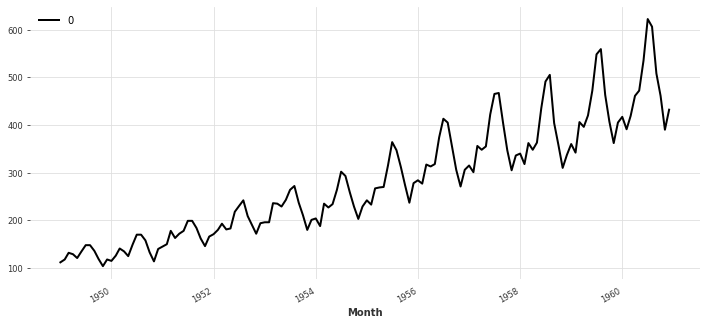

In [382]:
# plot the observations

plt.figure(100, figsize=(12, 5))
series.plot()

In [383]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? True
There is seasonality of order 12.


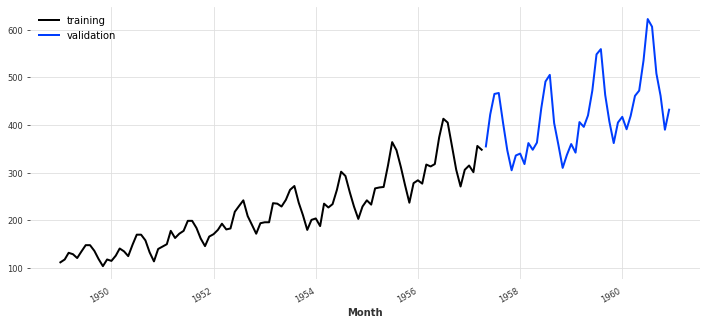

In [384]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split
if isinstance(TRAIN, numbers.Number):
    split_at = TRAIN
else:
    split_at = pd.Timestamp(TRAIN)
train, val = series.split_before(split_at)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [385]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid, t_start):
    n_act = len(act)
    res_mape = mape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    
    res_time = time.perf_counter() - t_start
    
    sr = resid.pd_series()
    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2, 
        "se": res_sefc, "time":res_time}
    return res_accuracy

In [386]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    n_val = len(val)
    res = model.fit(train)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    resid = forecast - val
    res_accuracy = accuracy_metrics(val, forecast, resid, t_start)
    
    
    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_accuracy["time"]) + " sec")
    return results

In [387]:
# prepare Naive forecaster

m_naive = NaiveDrift()

In [388]:
# prepare Exponential Smoothing forecaster

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()
    

In [389]:
# prepare Prophet forecaster

m_prophet = Prophet()    #frequency=mseas)

In [390]:
# prepare ARIMA forecaster

y = np.asarray(series.pd_series())
# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=TRACE, with_intercept="auto")
    

In [391]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100


In [392]:
# laundry list of forecasters to run

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet]

In [393]:
# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: Exponential smoothing
completed: Exponential smoothing:0.32140590000017255 sec
beginning: Theta(-3.1515151515151505)
completed: Theta(-3.1515151515151505):0.10481009999966773 sec
beginning: Auto-ARIMA
completed: Auto-ARIMA:0.977227600000333 sec
beginning: Naive drift model
completed: Naive drift model:0.0930225000001883 sec
beginning: Prophet
completed: Prophet:2.0015661999996155 sec


In [394]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,Exponential smoothing,Theta(-3.1515151515151505),Auto-ARIMA,Naive drift model,Prophet
MAPE,5.397,4.525,4.725,7.292,8.390
RMSE,33.628,23.937,24.717,42.724,41.930
-R squared,-0.807,-0.902,-0.895,-0.688,-0.699
se,6.981,6.079,6.170,7.534,9.035
time,0.321,0.105,0.977,0.093,2.002


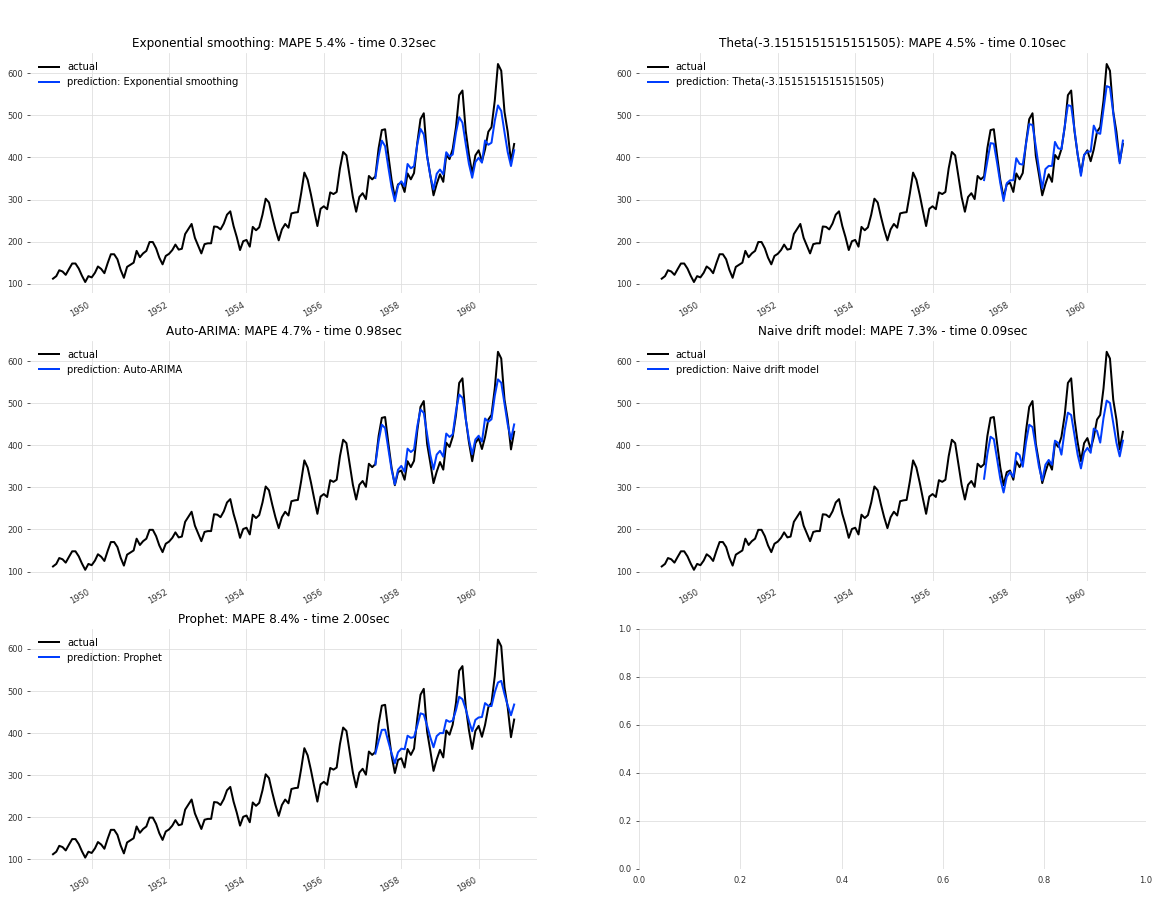

In [395]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()


In [396]:
act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]




Ljung-Box test for white-noise residuals: p-value > alpha?
Exponential smoothing : 4.1540137029846685e-07
Theta(-3.1515151515151505) : 1.4473990781826979e-05
Auto-ARIMA : 1.628237090182675e-05
Naive drift model : 9.379930722128882e-08
Prophet : 1.0184090678627992e-08

test for normality of residuals: p-value > alpha?
Exponential smoothing : 0.01867984506476661
Theta(-3.1515151515151505) : 0.905256966191541
Auto-ARIMA : 0.04253256181806027
Naive drift model : 0.17096643152873148
Prophet : 0.10584311858823182


[None, None, None, None, None]

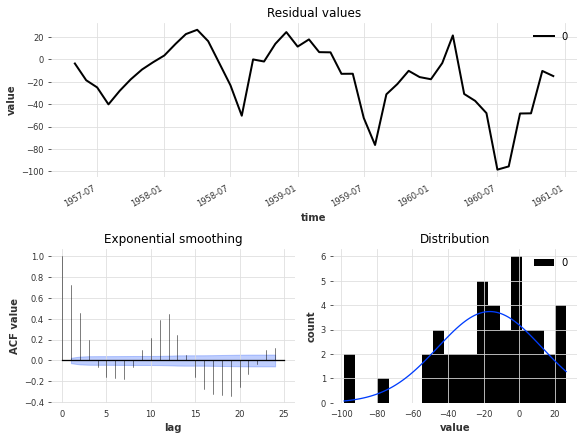

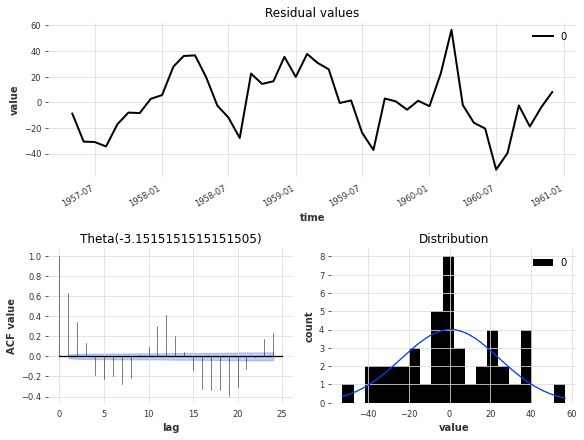

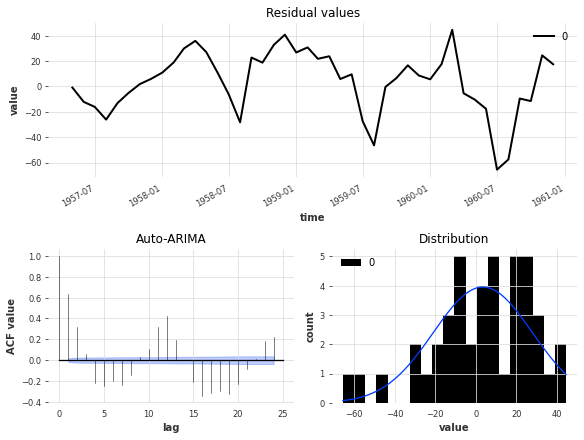

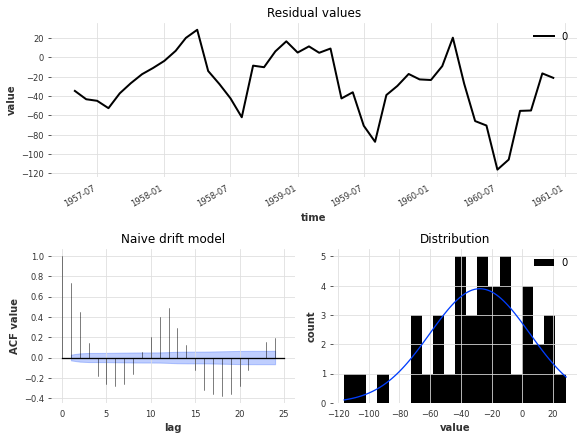

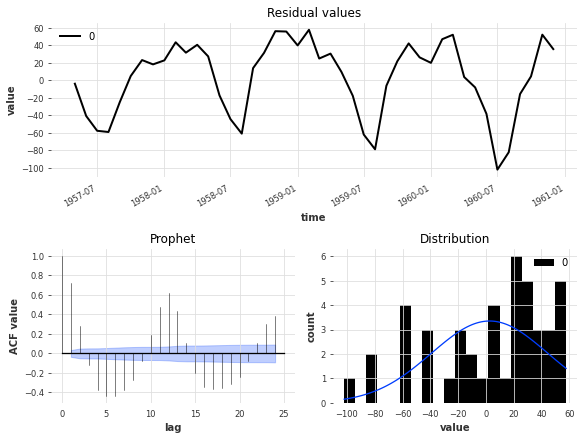

In [397]:
# investigate the residuals in the validation dataset

act = val
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act

        df_desc = pd.concat([df_desc, resid.describe()], axis=1)

        plot_residuals_analysis(resid);
        plt.title(str(m))
        

In [398]:
# descriptive statistics of the forecast series
df_desc.columns = [str(m) for m in models]
print(df_desc)

       Exponential smoothing  Theta(-3.1515151515151505)  Auto-ARIMA  \
count                 44.000                      44.000      44.000   
mean                 -16.558                       0.439       3.523   
std                   29.607                      24.210      24.747   
min                  -98.355                     -52.511     -65.549   
25%                  -30.987                     -16.182     -10.641   
50%                  -12.920                      -1.316       6.217   
75%                    4.102                      19.840      21.967   
max                   26.286                      56.620      44.575   

       Naive drift model  Prophet  
count             44.000   44.000  
mean             -27.614    2.689  
std               32.978   42.328  
min             -116.030 -101.985  
25%              -43.636  -19.460  
50%              -25.015   16.082  
75%               -7.242   32.640  
max               28.606   57.732  


# combine the individual models in an ensemble forecast:

In [399]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, val, models):
    t_start =  time.perf_counter()
    n_train = 50                # use 50 observation to train the ensemble model
    n_val = len(val)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    ensemble_model = RegressionEnsembleModel(
        forecasting_models = models,
        regression_train_n_points=n_train)


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - val


    res_accuracy = accuracy_metrics(val, forecast, resid, t_start)


    # plot the ensemble forecast
    series.plot(label="actual")
    forecast.plot(label="Ensemble forecast")
    plt.title("MAPE = {:.2f}%".format(res_mape))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


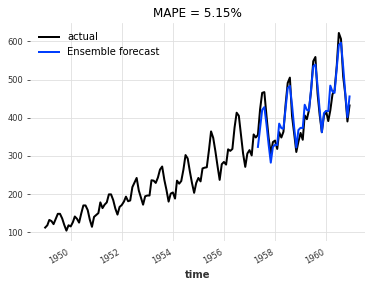

In [400]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["Expon", "Theta", "ARIMA", "Naive", "Prophet", "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
res_ensemble = ensemble_eval(train, val, models2)


In [401]:
# collect the accuracy metrics

print("Ensemble of all 5 forecasters:")

df_acc2 = df_acc.copy()
df_acc2["avg"] = df_acc2.mean(axis=1)
df_acc2["Ensemble"] = pd.Series(res_ensemble[1])
df_acc2.columns = col_heads
df_acc2.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

Ensemble of all 5 forecasters:


,Expon,Theta,ARIMA,Naive,Prophet,avg,Ensemble
MAPE,5.397,4.525,4.725,7.292,8.390,6.066,4.672
RMSE,33.628,23.937,24.717,42.724,41.930,33.387,23.319
-R squared,-0.807,-0.902,-0.895,-0.688,-0.699,-0.798,-0.907
se,6.981,6.079,6.170,7.534,9.035,7.160,5.963
time,0.321,0.105,0.977,0.093,2.002,0.700,8.764


Text(0.5, 1.0, 'Emsemble forecast')

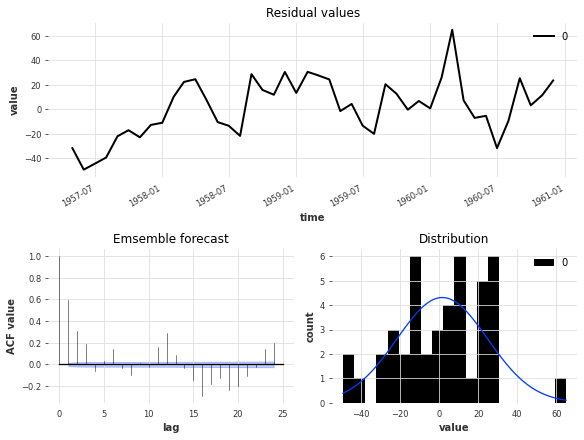

In [402]:
#resid = res_ensemble[2]

resid = res_ensemble[0] - val
sr = resid.pd_series()
plot_residuals_analysis(resid);
plt.title("Emsemble forecast")

In [403]:
resL = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
resN = normaltest(sr)[1]
   
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
print(resL)

print("\ntest for normality of residuals: p-value > alpha?")
print(resN)


Ljung-Box test for white-noise residuals: p-value > alpha?
0.0003060901805472148

test for normality of residuals: p-value > alpha?
0.9112867686408619
